# S.a.M: Music Recommender Feature


Hello! In this notebook we will be implementing the music recommendation system for our AI: S.a.M. S.a.M allows the user to input their favorite songs and get recommendations based off of it. This will be possible with the help of K-Means clustering and Content-based filtering.

Let's begin!


## Step 1: Loading the data

In order to start, we will have to import the necessary libraries and resources.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


We will now read the CSV file containing our dataset and put it in a pandas dataframe. In dataframe format, we will able to show important information such as the format of the dataset and its shape.

In [3]:
df = pd.read_csv('dataset.csv', index_col=0) #index_col=0 used to removed any unnamed columns which our dataset had one
df.head(10) #the head() function usually prints out the first 5 rows of the dataset but we will show the first 10

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic


In [4]:
print("The dimensions of our dataset are:", df.shape)

The dimensions of our dataset are: (114000, 20)


As seen above, our dataset consists of 114,000 songs with 20 features. These features consists of basic information of the song such as track name, artist, and album. But, it also has more interesting features that might be useful for use such as, loudness, acousticness, tempo, and genre. These can be useful when it comes to creating clusters.

## Step 2: Creating the clusters

For our recommendation system, we want to take in the user's input and output songs from a cluster that is most similar to our user's taste.

### Step 2a. Cleaning the data

Before implementing clusters, we first need to clean our data of unnecessary columns. Clustering works best if we keep features that are numerical values. This will make our recommendation system more interesting as we will be recommending songs that sound similar rather than something simple such as genre. To achieve this, we will drop columns that do not contain numerical data. We will also be dropping NaN columns which are columns that contain missing or incomplete data.

In [5]:
df.dropna(inplace=True) #we will first drop any NaN columns for efficiency
df.head(10)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic


In [6]:
#now we have to manually drop any remaining uneccessary columns such as 'track_id', 'explicit', and 'track_genre'
dropped_df = df.drop(['track_id', 'artists','album_name', 'track_name','explicit', 'track_genre'], axis=1)
dropped_df.head(10)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4
1,55,149610,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4
2,57,210826,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4
3,71,201933,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3
4,82,198853,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4
5,58,214240,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4
6,74,229400,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3
7,80,242946,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4
8,74,189613,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4
9,56,205594,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4


In [7]:
print("New dimensions of dataset:", dropped_df.shape)

New dimensions of dataset: (113999, 14)


Last step before implementing clusters is to normalize our data. If we did not do that, our graph would be skewed to favored larger values such as duration.

In [8]:
final_df = dropped_df.copy()
final_df = StandardScaler().fit_transform(final_df)
final_df = pd.DataFrame(final_df, columns=dropped_df.columns)
final_df.head(10)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,1.782624,0.024557,0.629239,-0.717147,-1.210434,0.300825,-1.326297,0.551843,-0.850193,-0.504111,0.758735,0.929315,-1.141854,0.221824
1,0.975625,-0.730889,-0.845908,-1.889974,-1.210434,-1.784739,0.753979,-0.078995,1.831744,-0.504097,-0.591216,-0.798681,-1.489708,0.221824
2,1.065291,-0.160353,-0.742187,-1.122667,-1.491334,-0.293289,0.753979,-0.273827,-0.315489,-0.504115,-0.507172,-1.365679,-1.528303,0.221824
3,1.692957,-0.243236,-1.733301,-2.312987,-1.491334,-2.039246,0.753979,-0.457309,1.774605,-0.503886,-0.428381,-1.276965,1.987857,-2.089669
4,2.186123,-0.271942,0.295026,-0.788709,-0.929534,-0.282751,0.753979,-0.303146,0.463409,-0.504115,-0.686290,-1.184394,-0.073343,0.221824
5,1.110125,-0.128534,0.698386,-0.637633,0.194067,-0.108971,0.753979,0.192445,-0.077910,-0.504115,-0.128976,0.740315,-0.804943,0.221824
6,1.827457,0.012758,-0.920818,-1.965512,-0.929534,-0.111953,0.753979,-0.464875,1.630253,-0.504105,-0.642167,-1.533465,0.638342,-2.089669
7,2.096457,0.139007,0.784820,-0.784734,1.598568,-0.213159,0.753979,-0.406236,0.734069,-0.504115,-0.610651,0.917743,0.961110,0.221824
8,1.827457,-0.358059,0.335362,-0.904004,-1.491334,-0.087696,0.753979,-0.451634,-0.062874,-0.504115,-0.328579,0.751887,0.264870,0.221824
9,1.020458,-0.209115,-0.719138,-0.037305,-1.210434,0.296053,0.753979,-0.521622,0.334094,-0.490579,-0.735666,-1.072537,-1.442674,0.221824


With our new data, we can now implement Kmeans Clusters!

### Step 2b: Elbow Method

For Kmeans Clusters to work, we need a certain k number of clusters. But we currently do not know the optimal amount of clusters for our data. We will be implementing the Elbow method to figure out our number of clusters.
> The Elbow method works by plotting the Inertia (sum of squared distances of samples to their closest cluster center) for n number of clusters and observing which cluster has a steep fall off.

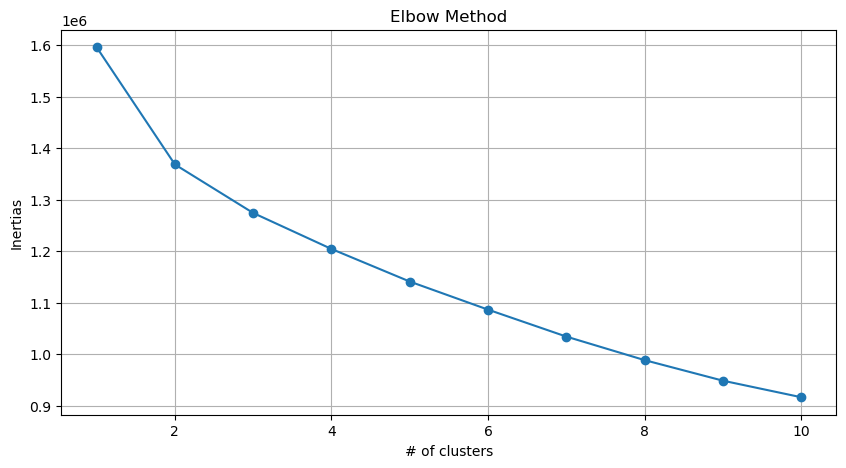

In [9]:
inertias = []
means = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(final_df)
    means.append(i)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(means, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel("# of clusters")
plt.ylabel("Inertias")
plt.grid(True)
plt.show()

We pick the point in which the inertia starts decreasing in a linear manner which appears to be point 3. We will be forming 3 clusters.

In [10]:
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(final_df)
df['Cluster'] = kmeans.labels_
final_df['Cluster'] = kmeans.labels_
df.head(10)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Cluster
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,1
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,2
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,2
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,2
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,2
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,...,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic,1
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,...,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic,2
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,...,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic,1
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,...,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic,1
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,...,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic,0


In [11]:
final_df.head(10)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
0,1.782624,0.024557,0.629239,-0.717147,-1.210434,0.300825,-1.326297,0.551843,-0.850193,-0.504111,0.758735,0.929315,-1.141854,0.221824,1
1,0.975625,-0.730889,-0.845908,-1.889974,-1.210434,-1.784739,0.753979,-0.078995,1.831744,-0.504097,-0.591216,-0.798681,-1.489708,0.221824,2
2,1.065291,-0.160353,-0.742187,-1.122667,-1.491334,-0.293289,0.753979,-0.273827,-0.315489,-0.504115,-0.507172,-1.365679,-1.528303,0.221824,2
3,1.692957,-0.243236,-1.733301,-2.312987,-1.491334,-2.039246,0.753979,-0.457309,1.774605,-0.503886,-0.428381,-1.276965,1.987857,-2.089669,2
4,2.186123,-0.271942,0.295026,-0.788709,-0.929534,-0.282751,0.753979,-0.303146,0.463409,-0.504115,-0.686290,-1.184394,-0.073343,0.221824,2
5,1.110125,-0.128534,0.698386,-0.637633,0.194067,-0.108971,0.753979,0.192445,-0.077910,-0.504115,-0.128976,0.740315,-0.804943,0.221824,1
6,1.827457,0.012758,-0.920818,-1.965512,-0.929534,-0.111953,0.753979,-0.464875,1.630253,-0.504105,-0.642167,-1.533465,0.638342,-2.089669,2
7,2.096457,0.139007,0.784820,-0.784734,1.598568,-0.213159,0.753979,-0.406236,0.734069,-0.504115,-0.610651,0.917743,0.961110,0.221824,1
8,1.827457,-0.358059,0.335362,-0.904004,-1.491334,-0.087696,0.753979,-0.451634,-0.062874,-0.504115,-0.328579,0.751887,0.264870,0.221824,1
9,1.020458,-0.209115,-0.719138,-0.037305,-1.210434,0.296053,0.753979,-0.521622,0.334094,-0.490579,-0.735666,-1.072537,-1.442674,0.221824,0


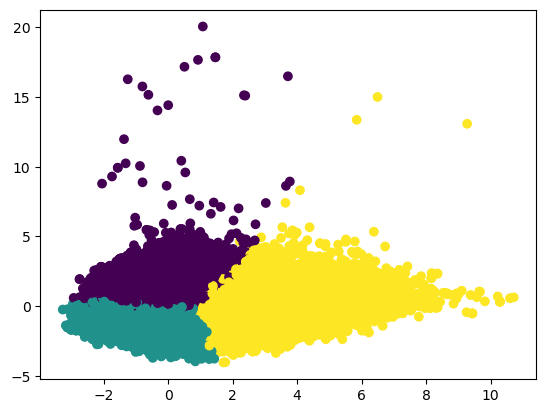

In [12]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(final_df.drop('Cluster', axis=1))
final_df['pca_1'] = principal_components[:,0]
final_df['pca_2'] = principal_components[:,1]

plt.scatter(final_df['pca_1'], final_df['pca_2'], c=final_df['Cluster'])
plt.show()

In [18]:
print(sum(pca.explained_variance_ratio_))

0.3215595253170453


In [13]:
def get_Song_Index(track_name, df):
    try:
        track_index = df[df['track_name'] == track_name].index[0]
        return track_index
    except IndexError:
        return None

In [14]:
def get_recommendations(track_name, df):
    track_index = get_Song_Index(track_name, df)
    print('You chose: ' + track_name + ' by ' + df.loc[track_index]['artists'])
    print('Here are your recommendations:')
    cluster = df.loc[track_index]['Cluster']
    
    filter = (df['Cluster'] == cluster)
    
    filtered_df = df[filter]
    
    for i in range(5):
        recommendation = filtered_df.sample()
        print(recommendation.iloc[0]['track_name'] + ' by ' + recommendation.iloc[0]['artists'])

In [15]:
get_recommendations('cardigan', df)

You chose: cardigan by Taylor Swift
Here are your recommendations:
Rebelde sem causa by Ultraje a Rigor
Un Reel by Ozuna;TINI
I Really Wish I Hated You by blink-182
Canto de Ossanha by Casuarina
A festa by Maria Rita
